In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import json
import os
from pandas.io.json import json_normalize
from functools import partial
from pdb import set_trace

from datetime import datetime, timedelta
import urllib.request

from fastai.vision.all import *
from fastai.tabular.all import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

ValueError: magics not found

In [2]:
import platform
sys = platform.system()

In [3]:
sys

'Linux'

In [4]:
url = URLs.MNIST
path = untar_data(url)

In [5]:
class PILImageBWNoised(PILImageBW): pass
class TensorImageBWNoised(TensorImageBW): pass
PILImageBWNoised._tensor_cls = TensorImageBWNoised

class PILImageTarget(PILImageBW): pass
class TensorImageTarget(TensorImageBW): pass
PILImageTarget._tensor_cls = TensorImageTarget

@Normalize
def encodes(self, to:TensorImageTarget): return to

class AddNoiseTransform(Transform):
    "Add noise to image"
    order = 11
    def __init__(self, noise_factor=0.1): self.noise_factor=noise_factor
    def encodes(self, o:TensorImageBWNoised): return (o + (self.noise_factor * torch.randn(*o.shape).to(o.device))).clamp(0,1)

mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBWNoised), ImageBlock(cls=PILImageTarget)), 
                 get_items=get_image_files,
                 get_x= [noop],
                 splitter=GrandparentSplitter(train_name='training' if url == URLs.MNIST else 'train', valid_name='testing' if url == URLs.MNIST else 'valid'),
                 batch_tfms=[AddNoiseTransform(0), Normalize()],
                 n_inp=1)

In [6]:
dls = mnist.dataloaders(path, num_workers=0 if sys != 'Linux' else 8, bs=1024)

In [7]:
class UnFlatten(Module):
    def __init__(self, size=7):
        self.size = size
    def forward(self, input):
        return input.view(input.size(0), -1, self.size, self.size)

class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32, dropout=.01):
        super(VAE, self).__init__()
        self.z_dim = z_dim
        kernel_size = 2
        self.encoder = nn.Sequential(
            ResBlock(1, 1, 16, act_cls=nn.ReLU, norm_type=None),
            nn.MaxPool2d(2, 2),
            ResBlock(1, 16, 4, act_cls=nn.ReLU, norm_type=None),
            nn.MaxPool2d(2, 2),
            Flatten()
        )
        
        last_size = model_sizes(self.encoder, size=(28,28))[-1][1]
        
        self.encoder = nn.Sequential(self.encoder, nn.Linear(last_size, z_dim))
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, last_size),
            UnFlatten(),
            ResBlock(1, 4, 8, ks=1, act_cls=nn.ReLU, norm_type=None),
            nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            ResBlock(1, 8, 16, act_cls=nn.ReLU, norm_type=None),
            nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(16, 1, 3, padding=1),
            nn.Dropout2d(dropout),
            nn.Sigmoid()
        )
        
        

    def encode(self, x):
        h = self.encoder(x)

        return h

    def decode(self, z):        
        img = self.decoder(z)
        return img

    def forward(self, x):
        z = self.encode(x)
        img = self.decode(z)
        return img, z
    
    def inference(self, n=1, c=None):

        batch_size = n
        z = torch.randn([batch_size, self.latent_size])

        recon_x = self.decoder(z, c)

        return recon_x
    
model = VAE(image_channels=1, h_dim=196, z_dim=128, dropout=.1).cuda()

In [8]:
class Reshape(nn.Module):
    '''
        Used in a nn.Sequential pipeline to reshape on the fly.
    '''
    def __init__(self, *target_shape):
        super().__init__()
        self.target_shape = target_shape
    
    def forward(self, x):
        return x.view(*self.target_shape)

In [9]:
class MMD_VAE(Module):
    def __init__(self, latent_size):        
        self.encoder = nn.Sequential(
            ResBlock(1, 1, 5, stride=2, act_cls=Mish),
            ResBlock(1, 5, 5, stride=2, act_cls=Mish),
            ResBlock(1, 5, 1, stride=2, act_cls=Mish),
            Flatten(),
            nn.Linear(16, latent_size)
        )
        
        dropout=0
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 16),
            UnFlatten(4),
            ResBlock(1, 1, 4, act_cls=Mish),
            nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            ResBlock(1, 4, 8, act_cls=Mish),
            nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            ResBlock(1, 8, 16, act_cls=Mish),
            nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(16, 1, 3),
            nn.Dropout2d(dropout),
            nn.AdaptiveAvgPool2d((28, 28)),
            nn.Sigmoid()
        )
        
#         last_size = model_sizes(self.decoder, size=(16,16))[-1][1]
#         breakpoint()
    
    def forward(self, X):
        latent = self.encoder(X)
        return self.decoder(latent), latent

In [10]:
onebatch = dls.one_batch()
img, targets_img = onebatch

In [11]:
model = MMD_VAE(4).cuda()
with torch.no_grad():
    res = model(img)

In [12]:
res[0].shape

torch.Size([1024, 1, 28, 28])

In [13]:
class L2Metric(Metric):
    def __init__(self): self.preds = []
    def accumulate(self, learn):
        x = to_detach(learn.y)
        recon_x = to_detach(learn.pred[0])
        nll = torch.mean((recon_x - x)**2)
        self.preds.append(nll)
    @property
    def value(self):
        return np.array(self.preds).mean()
    
class MMDMetric(Metric):
    def __init__(self, alpha=1):
        self.preds = []
        store_attr('alpha')
        
    def accumulate(self, learn):
        
        z = to_detach(learn.pred[1])
        hidden_size = z.shape[1]
        true_samples = torch.randn((learn.pred[0].shape[0],hidden_size), requires_grad=False)

        mmd_loss = MMD(true_samples, z) * self.alpha
        
        self.preds.append(mmd_loss)
    @property
    def value(self):
        return np.array(self.preds).mean()

def gaussian_kernel(a, b):
    dim1_1, dim1_2 = a.shape[0], b.shape[0]
    depth = a.shape[1]
    a = a.view(dim1_1, 1, depth)
    b = b.view(1, dim1_2, depth)
    a_core = a.expand(dim1_1, dim1_2, depth)
    b_core = b.expand(dim1_1, dim1_2, depth)
    numerator = (a_core - b_core).pow(2).mean(2)/depth
    return torch.exp(-numerator)

def MMD(a, b):
    return gaussian_kernel(a, a).mean() + gaussian_kernel(b, b).mean() - 2*gaussian_kernel(a, b).mean()
    
    
class LossVAE(Module):
    def __init__(self, alpha=1):
        store_attr('alpha')
        
    def forward(self, output, x):
        recon_x, z = output
    
        bs = recon_x.shape[0]
        hidden_size = z.shape[1]

        nll = torch.mean((recon_x - x)**2)

        true_samples = torch.randn((bs,hidden_size), requires_grad=False).cuda()

        mmd_loss = MMD(true_samples, z) * self.alpha

        return nll + mmd_loss

In [14]:
@typedispatch
def wandb_process(x:tuple, y:TensorImageTarget, samples, outs):
    img_input, category = x
    img_preds, z = outs
    
    img_inputs = []
    for img, cat,target,pred in zip(img_input, category, y, img_preds):
        i = torch.cat([img.clamp(0,1), target, pred], dim=2).squeeze(0)
        img_inputs += [wandb.Image(i)]
    
    return {"Predictions": img_inputs}

In [15]:
import wandb
from fastai.callback.wandb import *

# wandb.init(project='VAE-MNIST-MMD')

alpha = 1
hidden_size = 128

class WandbCallbackCustom(WandbCallback):
    def log_predictions(self, preds):
        inp,preds,targs,out = preds
        tolog = wandb_process(inp, targs, inp, preds)
        
#         num = 10 if url == URLs.MNIST else 2
#         fig, axes = plt.subplots(ncols=num, nrows=10, figsize=(19,19))
        
#         i = 0
#         with torch.no_grad():
#             self.model.eval()
#             for row in axes:
#                 z = torch.empty([num,128]).normal_().cuda()
#                 img = self.model.decode(z.half(), torch.Tensor(range(num)).long().cuda()).detach().cpu().float()
#                 for ax in row:
#                     ax.imshow(img[i%num][0], cmap='Greys')
#                     ax.axis('off')`
#                     ax.set_title(str(i%num))
#                     i += 1
#             self.model.train()
        
#         tolog['Samples'] = [wandb.Image(fig)]
        
        wandb.log(tolog, step=self._wandb_step)
        
def prepare_preds(preds):
    inp,preds,targs,out = preds
    return inp, targs, inp, preds


cbs=[]
# cbs += [EarlyStoppingCallback(patience=2)]
# cbs += [WandbCallbackCustom(reorder=False, n_preds=20)]

In [16]:
# model = VAE(image_channels=1, h_dim=196, z_dim=128).cuda()
model = MMD_VAE(4)

learn = Learner(dls, model, cbs=cbs, loss_func=LossVAE(alpha), metrics=[L2Metric(), MMDMetric(alpha)],opt_func=ranger)
learn = learn.to_fp16()

In [17]:
learn.fit_one_cycle(30)

# learn.save(datetime.now().strftime('%Y-%m-%d %Hh%M.%S') + '.model')

epoch     train_loss  valid_loss  l2        mmd       time    
0         0.326542    0.330630    0.255259930.07630171600:23     
1         0.317615    00:15       


KeyboardInterrupt: 

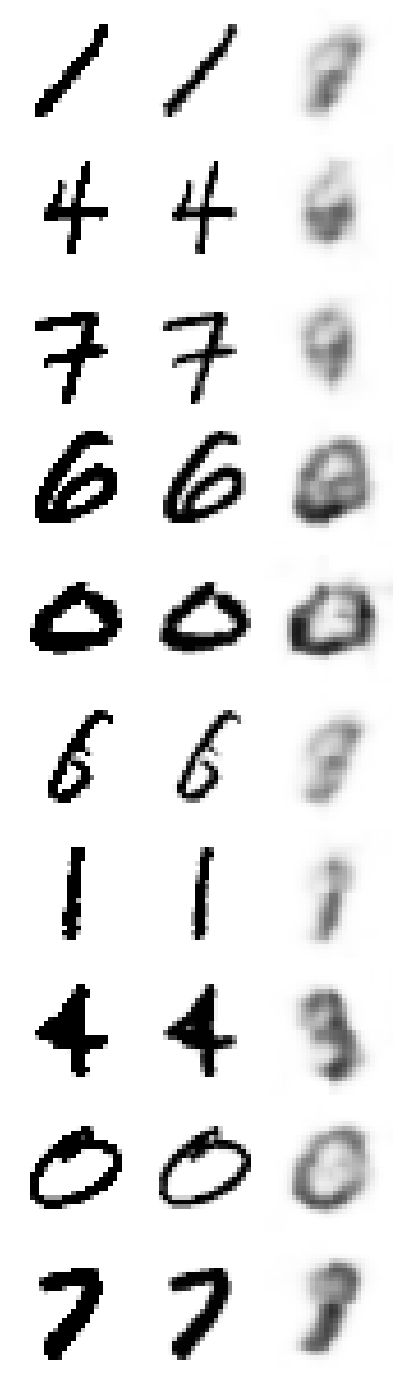

In [265]:
b = learn.dls[0].one_batch()
input_img, targets = to_detach(b)
preds, targs = learn.get_preds(dl=[b], reorder=False)
imgs, _ = preds

_, axes = plt.subplots(ncols=1, nrows=10, constrained_layout=True, figsize=(10, 19))
i = 0
for a in axes:
#     a.set_title(nums[i].cpu().item())
    img = torch.cat([input_img.clamp(0,1), targs, imgs], dim=3)[i].squeeze(0).cpu()
    a.imshow(img, cmap='Greys')
    a.axis('off')
    i = i + 1

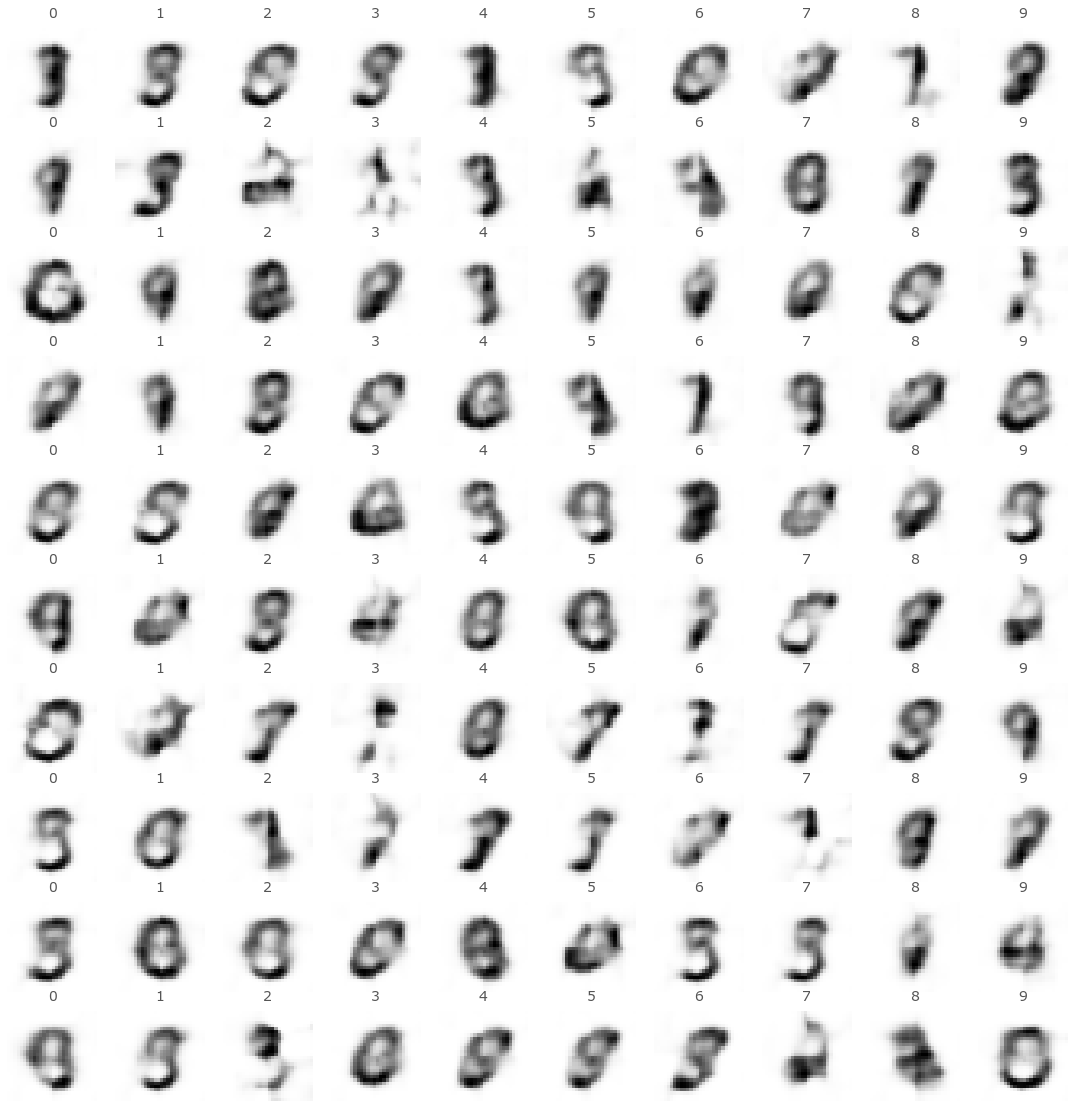

In [266]:
# %debug
num = 10 if url == URLs.MNIST else 2
_, axes = plt.subplots(ncols=num, nrows=10, figsize=(19,19))
learn.model.eval()
i = 0
with torch.no_grad():
    for row in axes:
        z = torch.empty([num,4]).normal_().cuda()
        img = learn.model.decoder(z).detach().cpu()
        for ax in row:
            ax.imshow(img[i%num][0], cmap='Greys')
            ax.axis('off')
            ax.set_title(str(i%num))
            i += 1

In [267]:
from itertools import product

#Manages device/graph status/type handling
def from_latent(net, vec):
    with torch.no_grad():
        net.eval()
        return net.decoder( torch.tensor(vec).to('cuda').float()[None,:] ).cpu().detach().numpy().reshape(28,28)

def get_sampling_grid(net, grid):
    base = torch.randn(4-2)
    image = torch.tensor([])
    for vec in grid:
        image = torch.cat([image, torch.from_numpy(from_latent(net, np.hstack([vec, base]) ) ) ] )
    return image.view(64,1,28,28)

def sample_from_latent(net, save = True, location = 'grid.png'):
    grid = list(product(np.linspace(-1,1,8), np.linspace(-1,1,8) ) )
    results = get_sampling_grid(net, grid)
    if save:
        save_image(results, location)
    return results

from torchvision.utils import make_grid
def show_image_grid(results):
    img = make_grid(results, nrow = 8)
    _, ax = plt.subplots(ncols=1, nrows=1, figsize=(19,19))
    ax.imshow(img.permute(1,2,0))

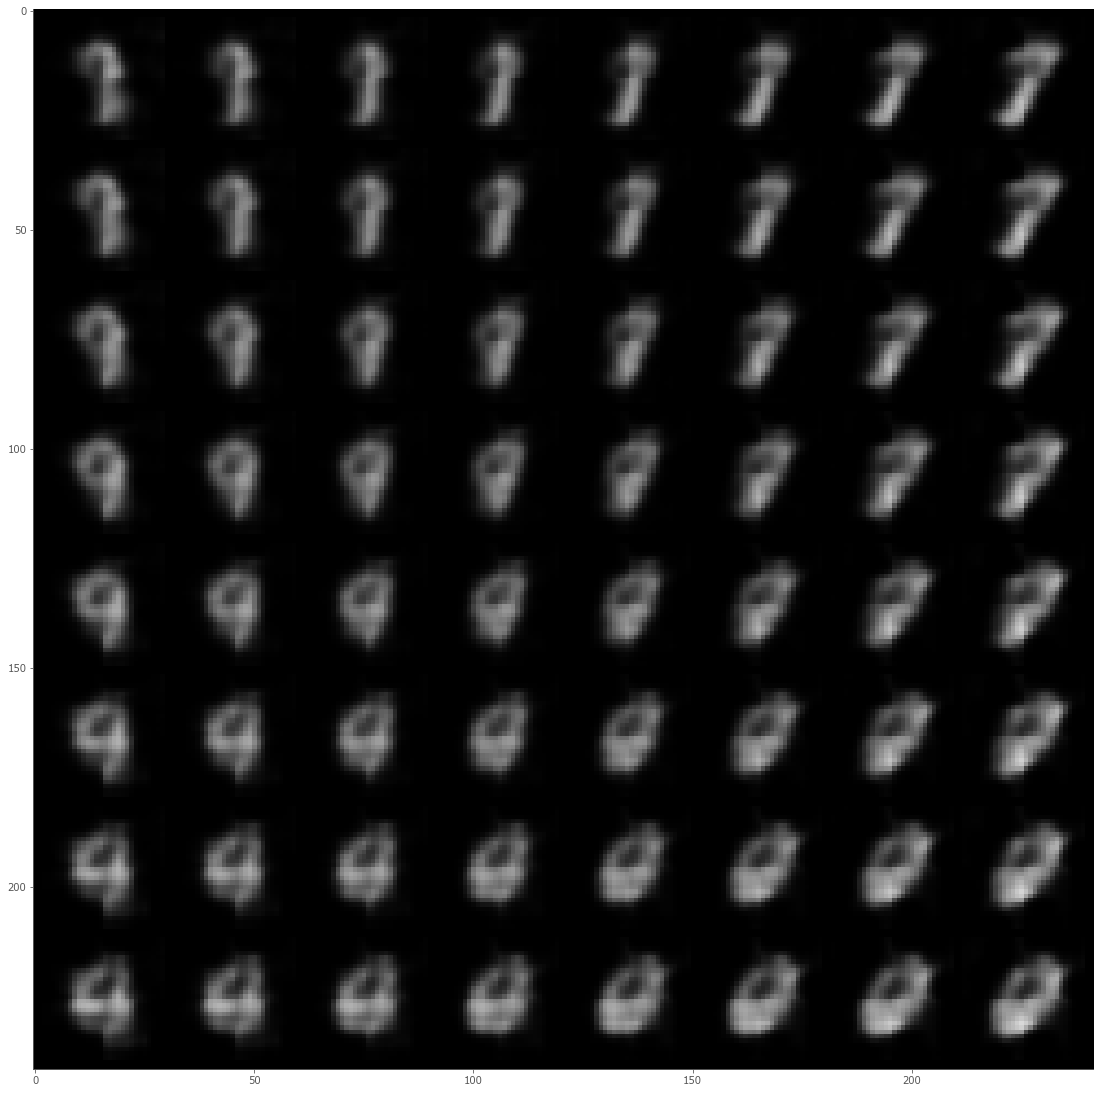

In [268]:
sampled_images = sample_from_latent(learn.model, save = False)

show_image_grid(sampled_images)